## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os
import os.path
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio


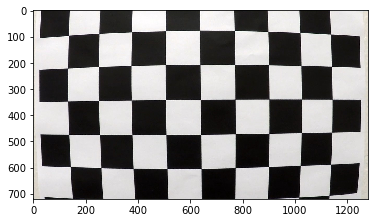

In [2]:
# Set the number of corners
nx = 9
ny = 6
# Read in the first image as the test_image
f = os.listdir('camera_cal/')
test_img = mpimg.imread('camera_cal/'+f[0])
gray = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
plt.imshow(test_img)

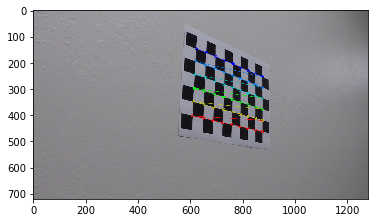

In [3]:
### Calibrate camera
objpoints = []
imgpoints = []
# Creat the object points and initialize all 0
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
for filename in f:
    img = mpimg.imread('camera_cal/'+filename)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        plt.imshow(img)
        plt.savefig('output_images/camera_cali/'+'corners_'+filename)
# Perform the camera calibration, image distortion correction and returns the undistoted image
ret, mtx,dist, revecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)


### Apply a distorsion correction to the chessborad image

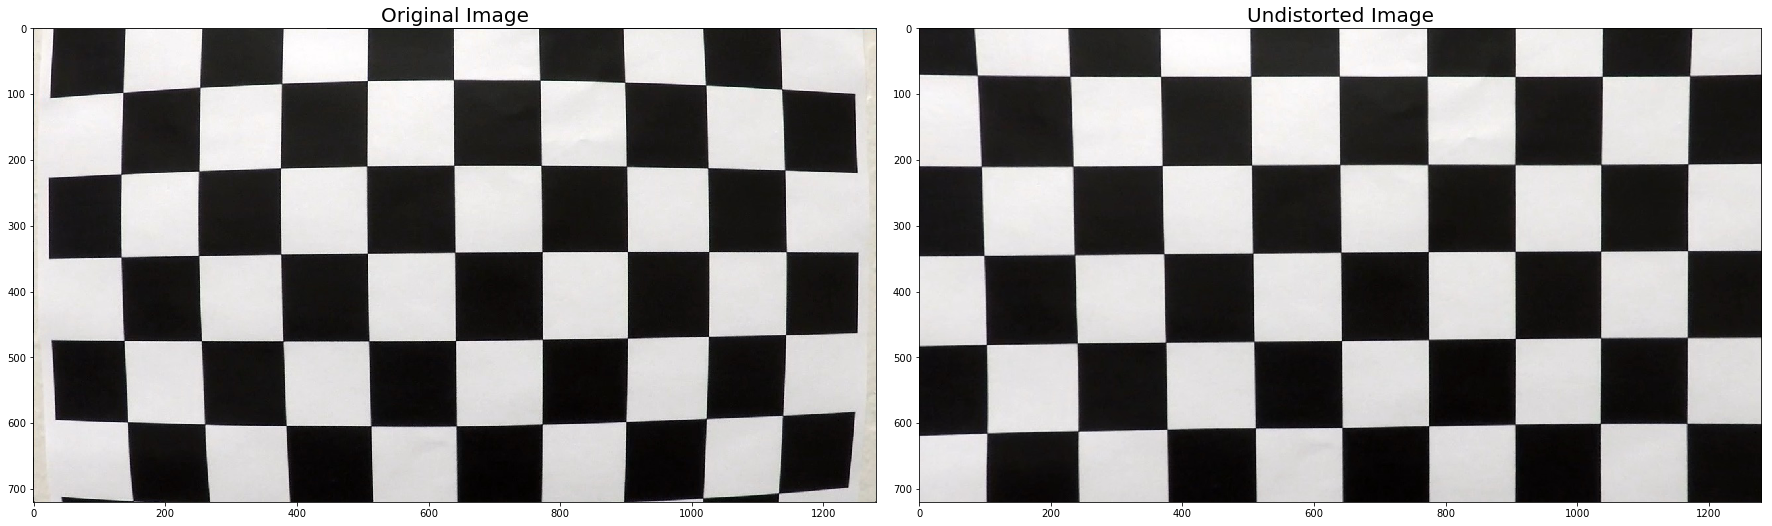

In [4]:
# Comparison of undistorted chessboard image and original image
undist = cv2.undistort(test_img,mtx,dist,None,mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/camera_cali/undistort_test_imgage')


### Use color transforms, gradients, etc., to create a thresholded binary image.

### Sobelx + Direction

In [5]:
# Define a function that apllies sobel x, sobel y and sobel direction
# then takes an absolute value and calculate sobel dir
# apllies a threshold
def sobel(img, sobel_kernel=3, sobelx_thresh=(25,255), dir_thresh = (0,np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    abs_sobelx = abs(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobely = abs(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sobel_dir = np.arctan2(abs_sobely,abs_sobelx)
    sobel_dir = abs(sobel_dir)
    
    sobel_binary = np.zeros_like(scaled_sobelx)
    sobel_binary[(scaled_sobelx>sobelx_thresh[0]) & (scaled_sobelx<sobelx_thresh[1])& 
                (sobel_dir>dir_thresh[0]) & (sobel_dir<dir_thresh[1])] = 1
    
    return sobel_binary

### RGB threshold

In [6]:
# Define a function that applies RGB select to select yellow and white color
def RGB_select(img,  yellow_thresh=0, white_thresh=0):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    yellow_select = np.zeros_like(R)
    yellow_select[(R > yellow_thresh) & (G > yellow_thresh)] = 1
    white_select = np.zeros_like(R)
    white_select[(R > white_thresh) & (G > white_thresh) & (B > white_thresh)]
    combined_binary = np.zeros_like(white_select)
    combined_binary[(yellow_select == 1) | (white_select == 1)] = 1
    return combined_binary

### HLS - S + L channel threshold

In [7]:
# Define a function that convert the RGB color space into HLS color space
# applies thresholds to s and l channel
def hls_select(img, s_thresh=(0,255), l_thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel>s_thresh[0]) & (s_channel<s_thresh[1]))] = 1
    l_channel = hls[:,:,1]
    l_binary = np.zeros_like(l_channel)
    l_binary[((l_channel>l_thresh[0]) & (l_channel<l_thresh[1]))] = 1
    return s_binary, l_binary

### LAB - B channel threshold

In [8]:
# Define a funtion that applies threshold to the B channel of the LAB color space 
def lab_select(img, b_thresh=(0,255)):
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    if np.max(b_channel) > 175:
        b_channel = 255*(b_channel/np.max(b_channel))
    b_binary = np.zeros_like(b_channel)
    b_binary[((b_channel <= b_thresh[1]) & (b_channel > b_thresh[0]))] = 1
    return b_binary    

### Perspective Transform

In [9]:
# Define the perspective transform function:
#1）change the view of the image from camera view into bird view
#2) change the view of the image from bird view into camera view (inverse perspective transform)
def warp(img):
    img_size = (img.shape[1],img.shape[0])
    #src = np.float32([
        #[220,720],
        #[1110, 720],
        #[598, 450],
        #[691, 450]
    #])
    #dst = np.float32([
        #[320,720],
        #[920, 720],
        #[320, 1],
        #[920, 1]
    #])
    src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    dst = np.float32([(320,1),
                  (920,1),
                  (320,720),
                  (920,720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    warped_inv = cv2.warpPerspective(img,Minv,img_size)
    return warped,warped_inv

In [10]:
# Define a funciton to combine all the above binary images
# Apply perspective transform
def warp_binary(img):
    img = cv2.undistort(img,mtx,dist,None,mtx)
    sobel_bi = sobel(img, sobel_kernel=3, sobelx_thresh=(10,255), dir_thresh = (np.pi/6,np.pi/2))
    RGB_bi = RGB_select(img, yellow_thresh=150, white_thresh=180)
    s_binary, l_binary = hls_select(img,s_thresh=(120,255), l_thresh=(170,255))
    b_binary = lab_select(img, b_thresh=(190,255))
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((RGB_bi == 1) & (l_binary == 1)) & 
                    ((s_binary == 1)|(sobel_bi == 1)) |
                   (b_binary == 1)] = 1    
    #combined_binary[(b_binary == 1)] = 1
    binary_warped,_ = warp(combined_binary)    
    return combined_binary,binary_warped

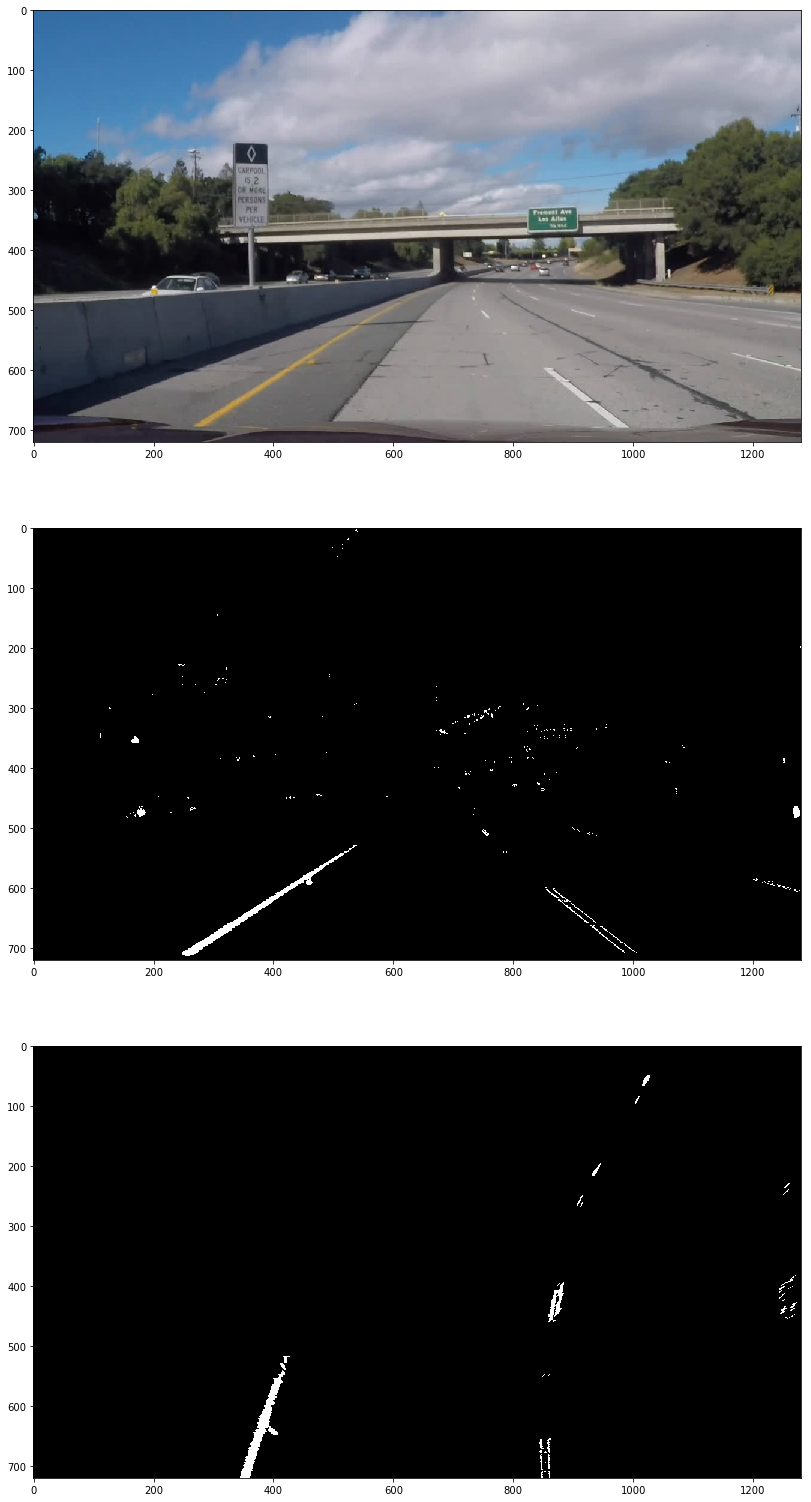

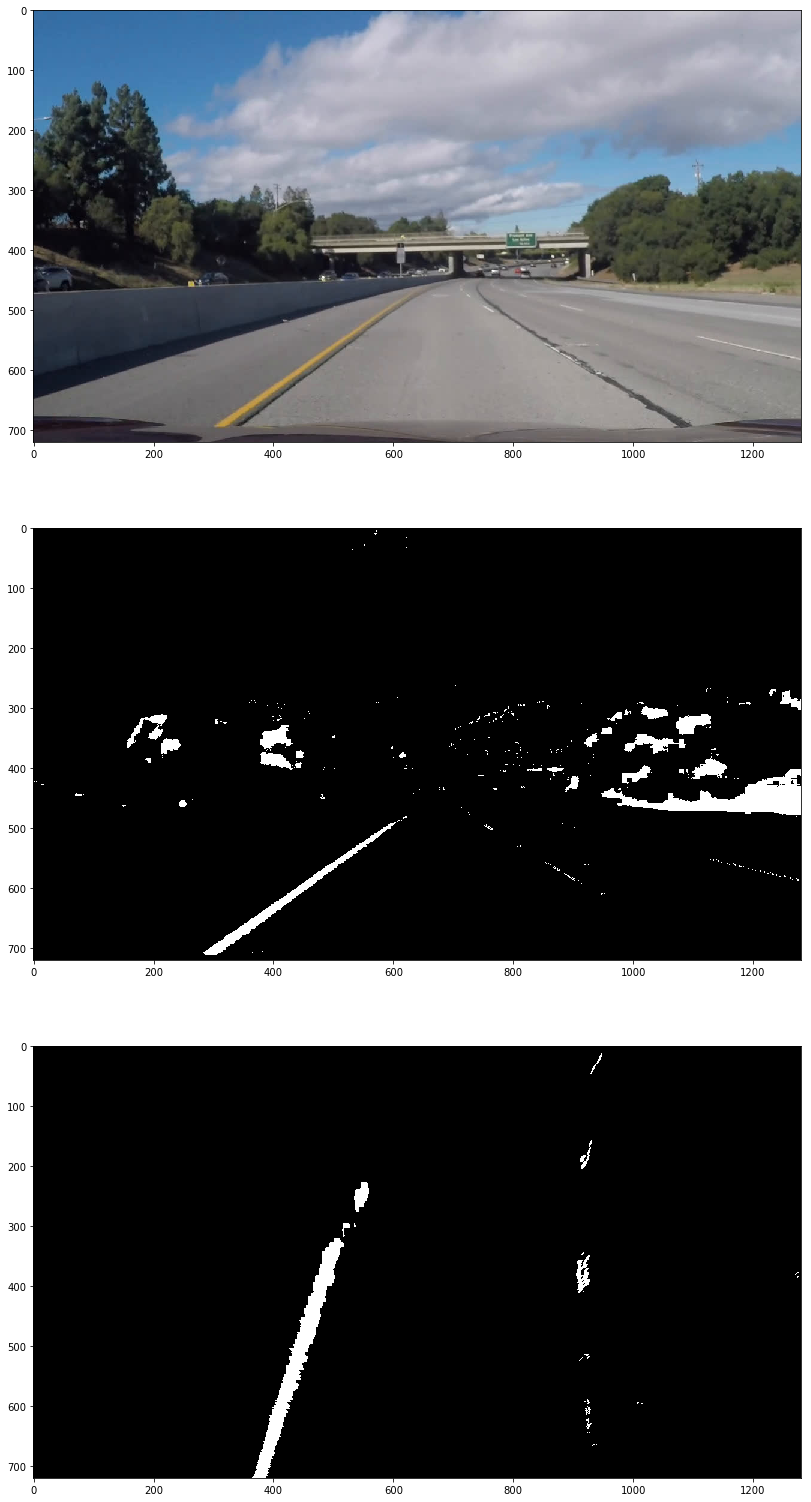

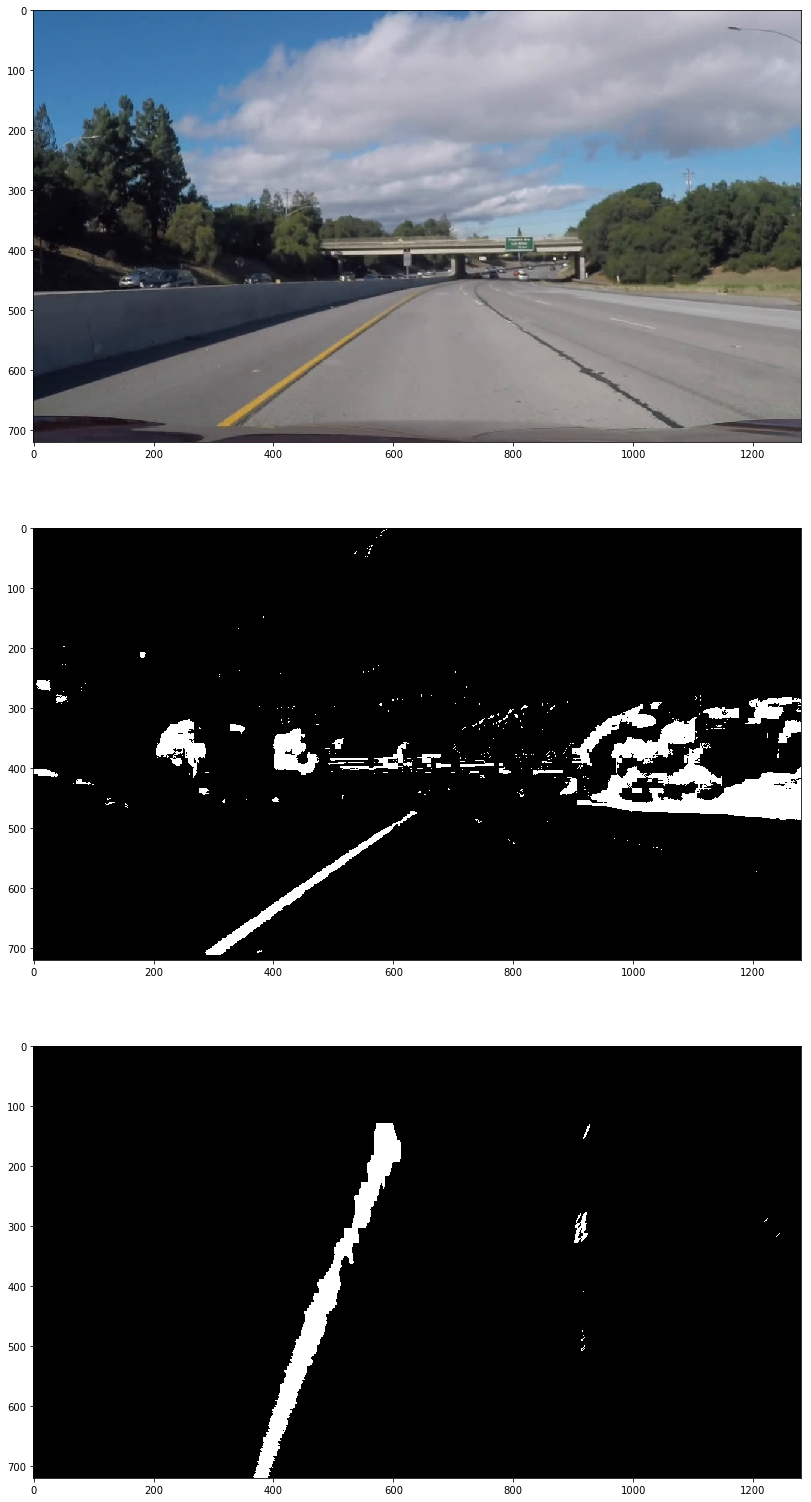

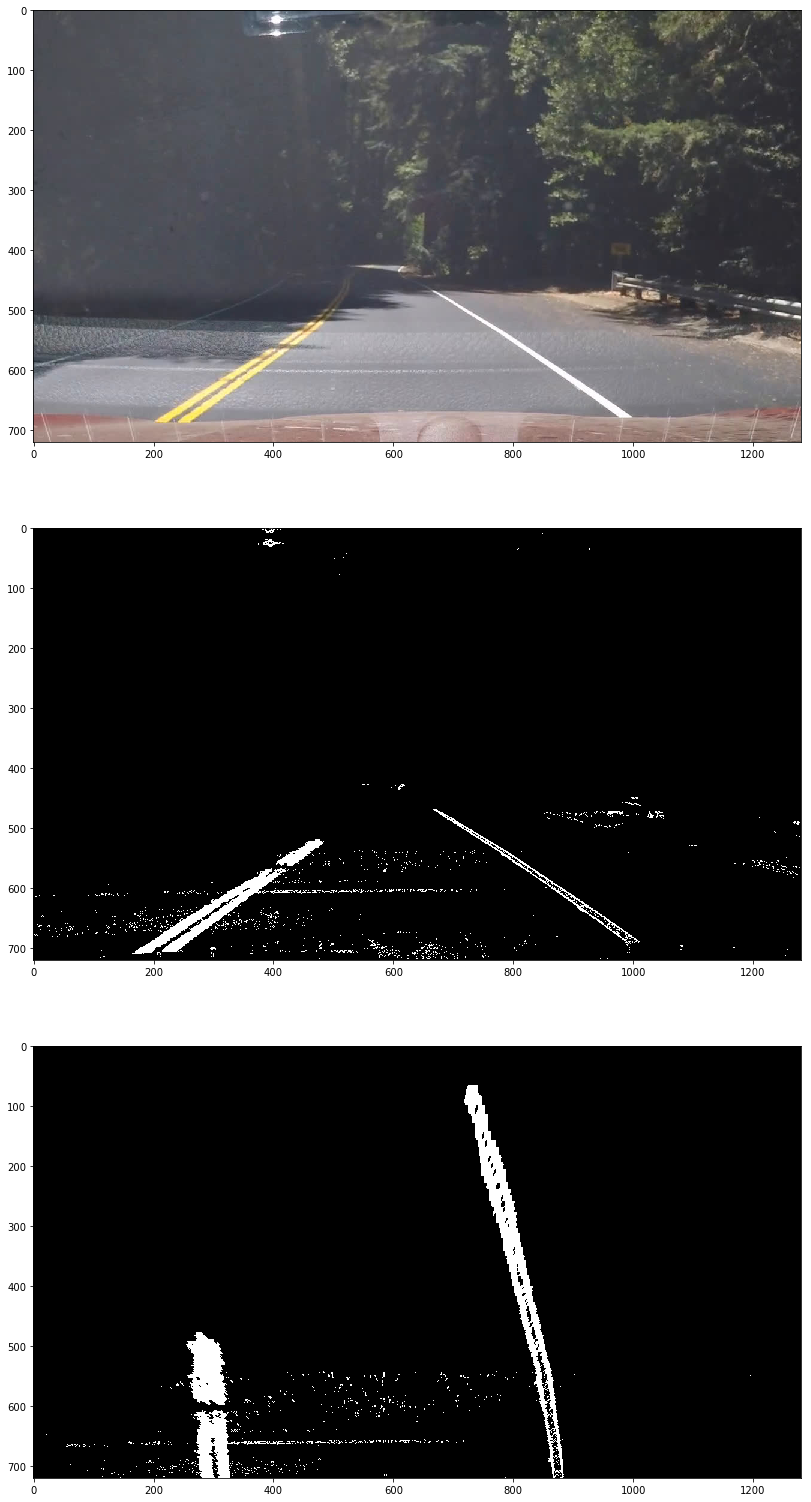

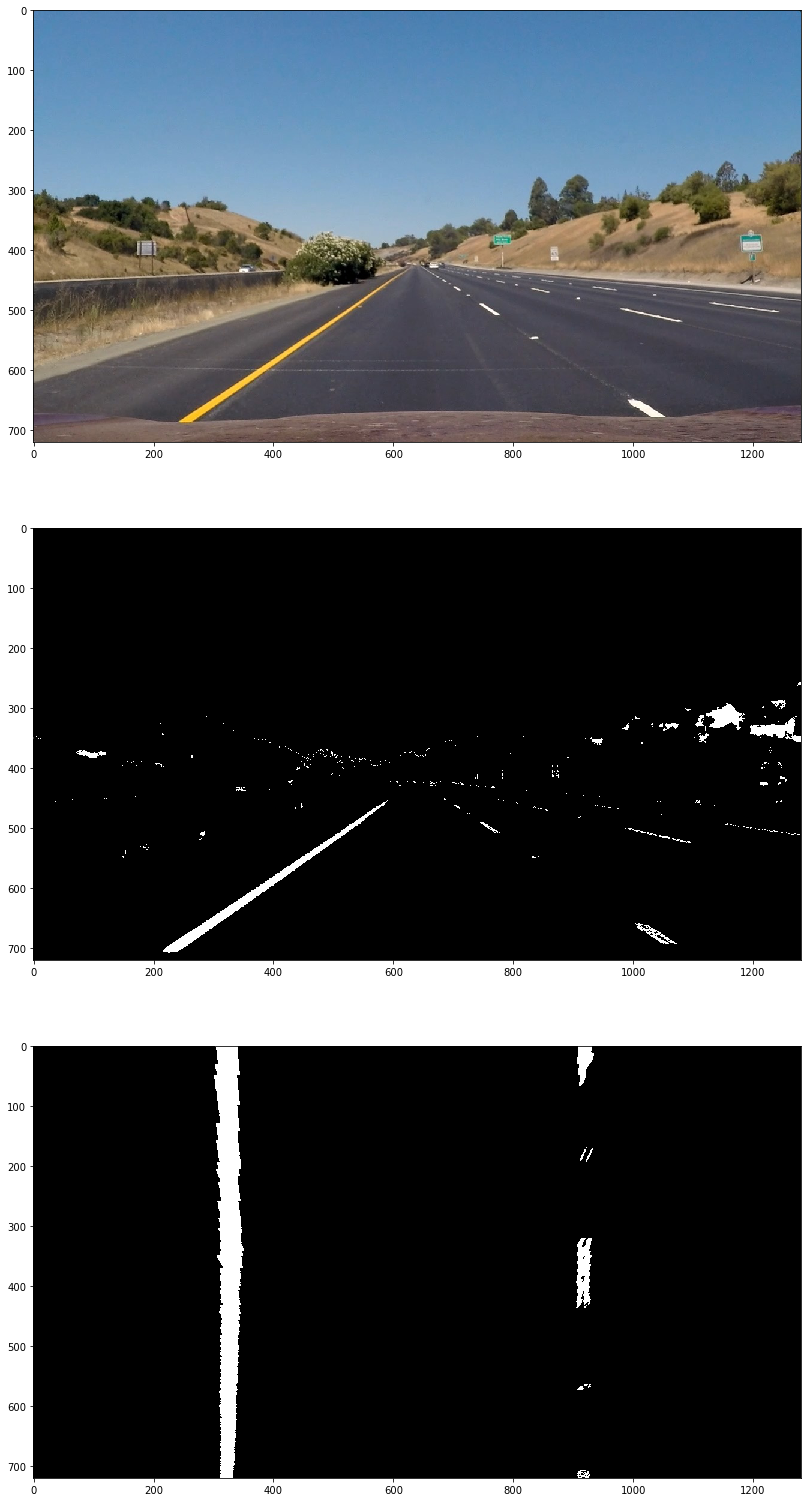

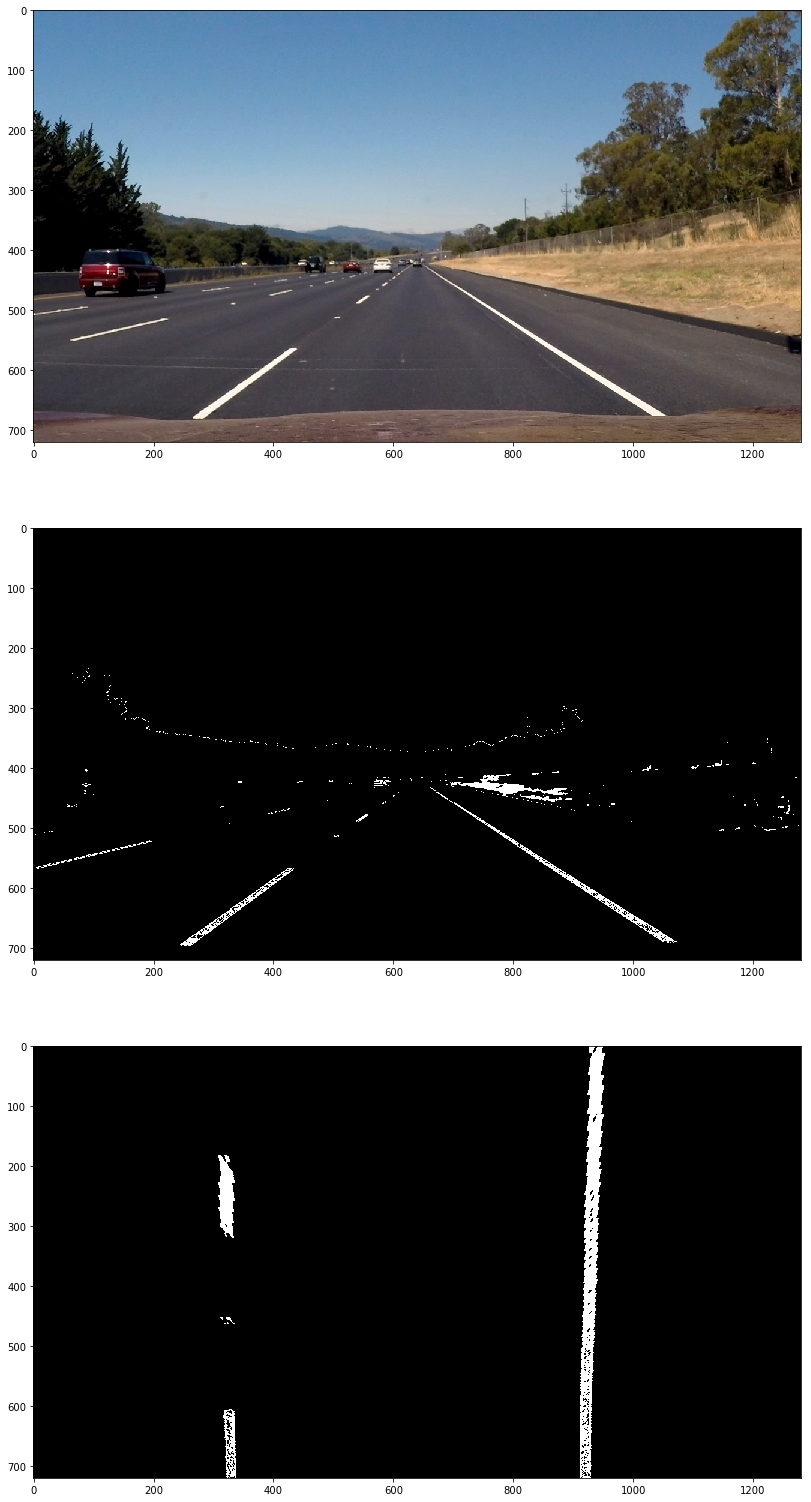

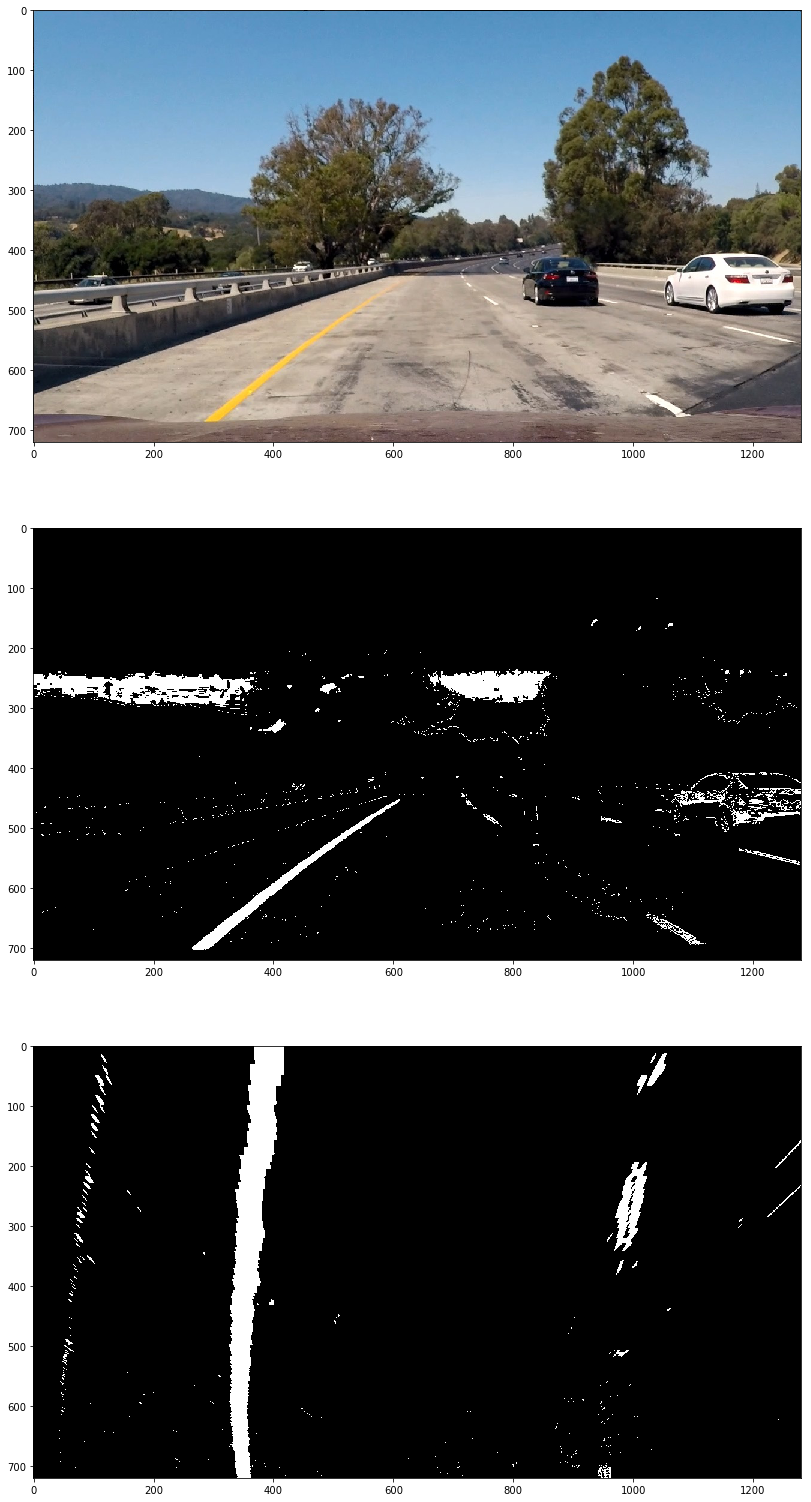

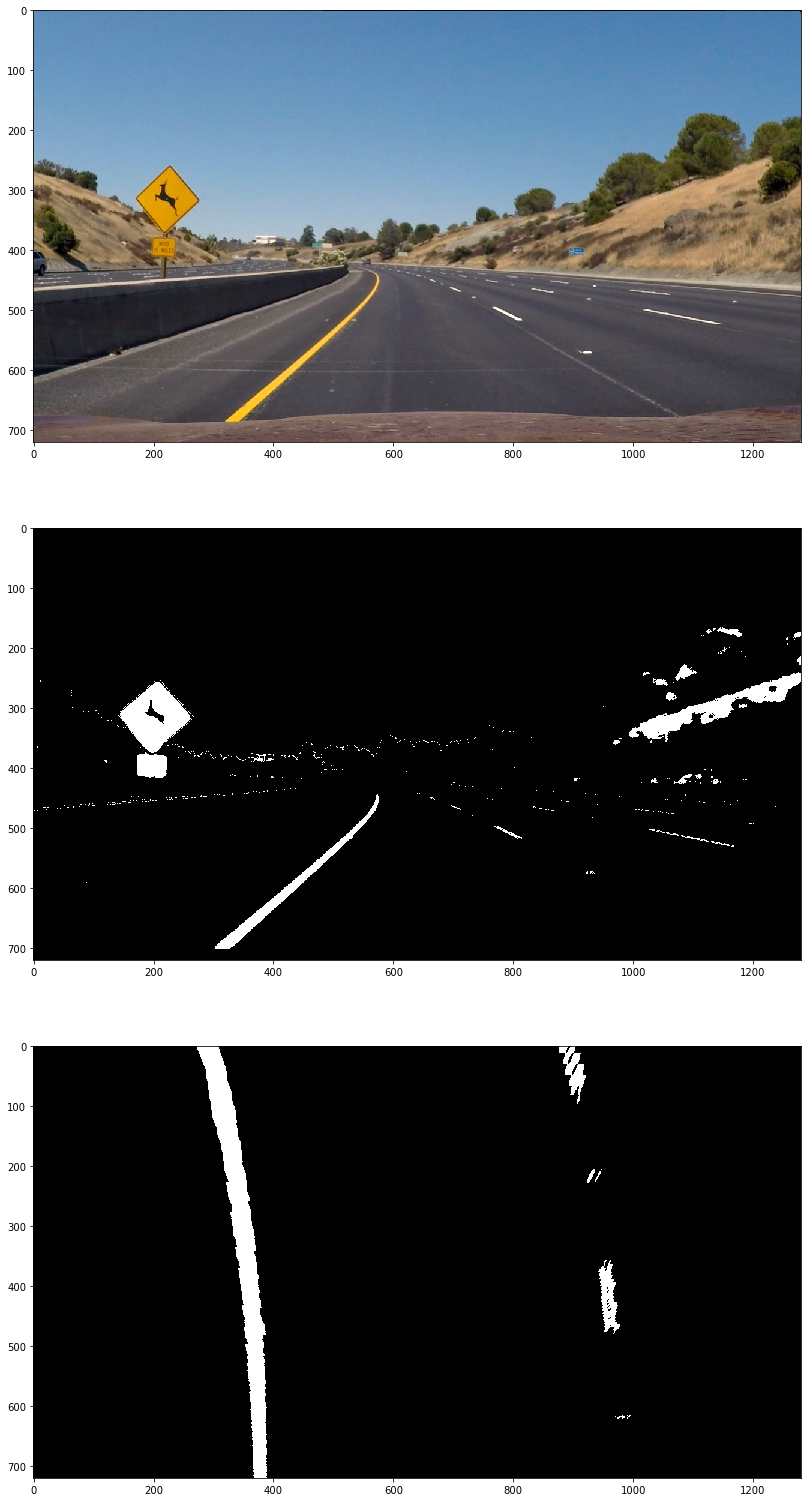

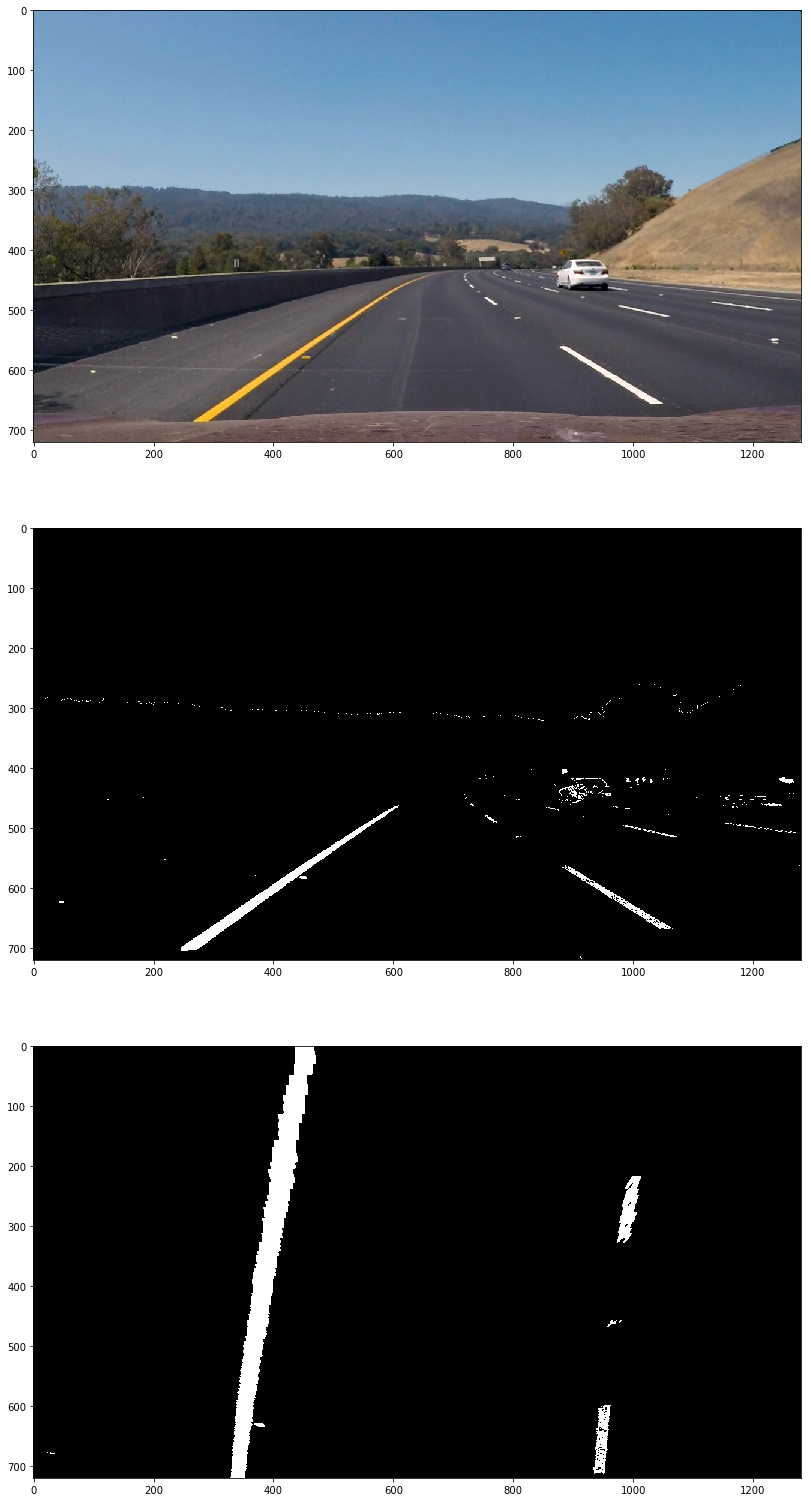

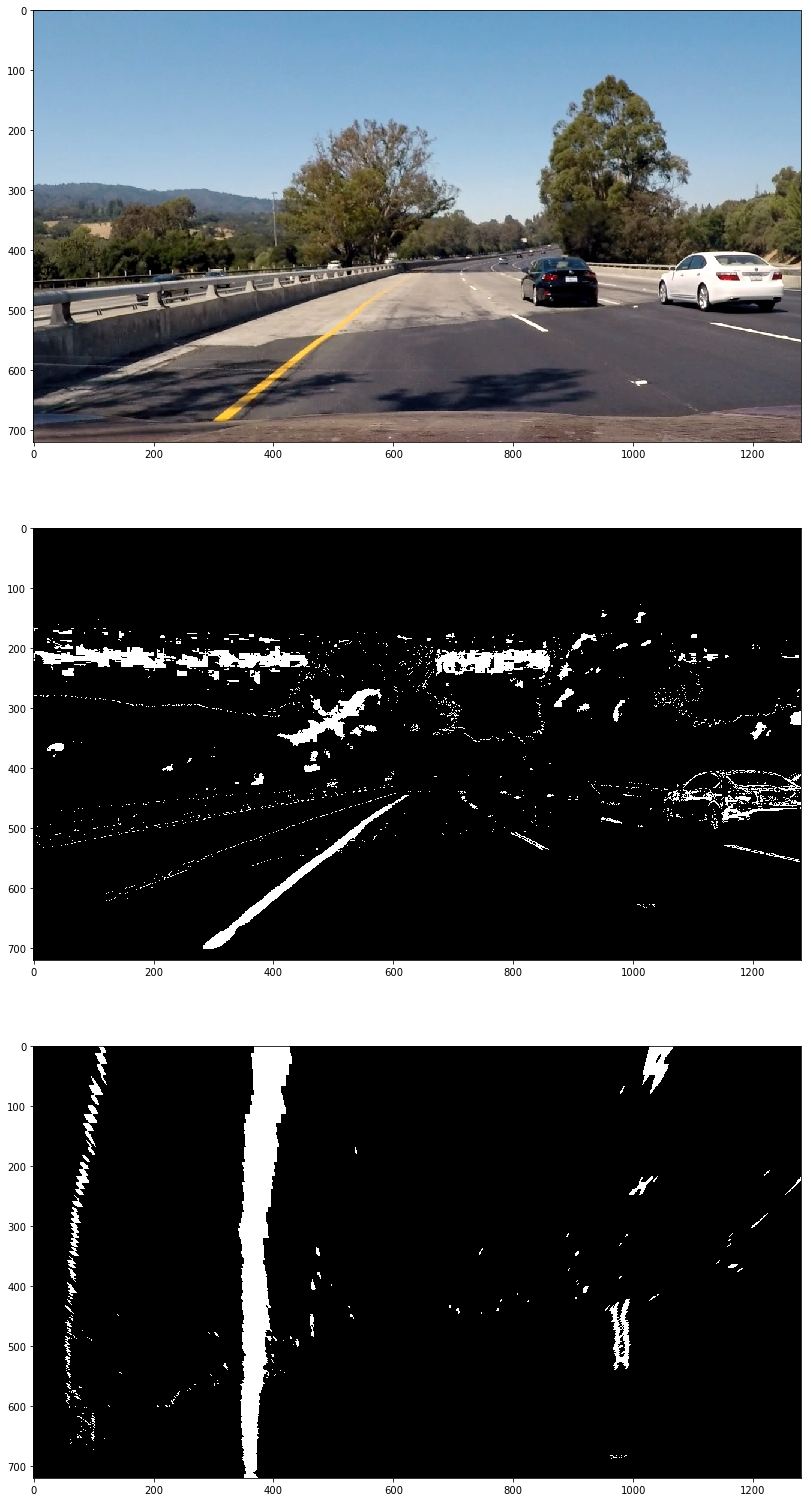

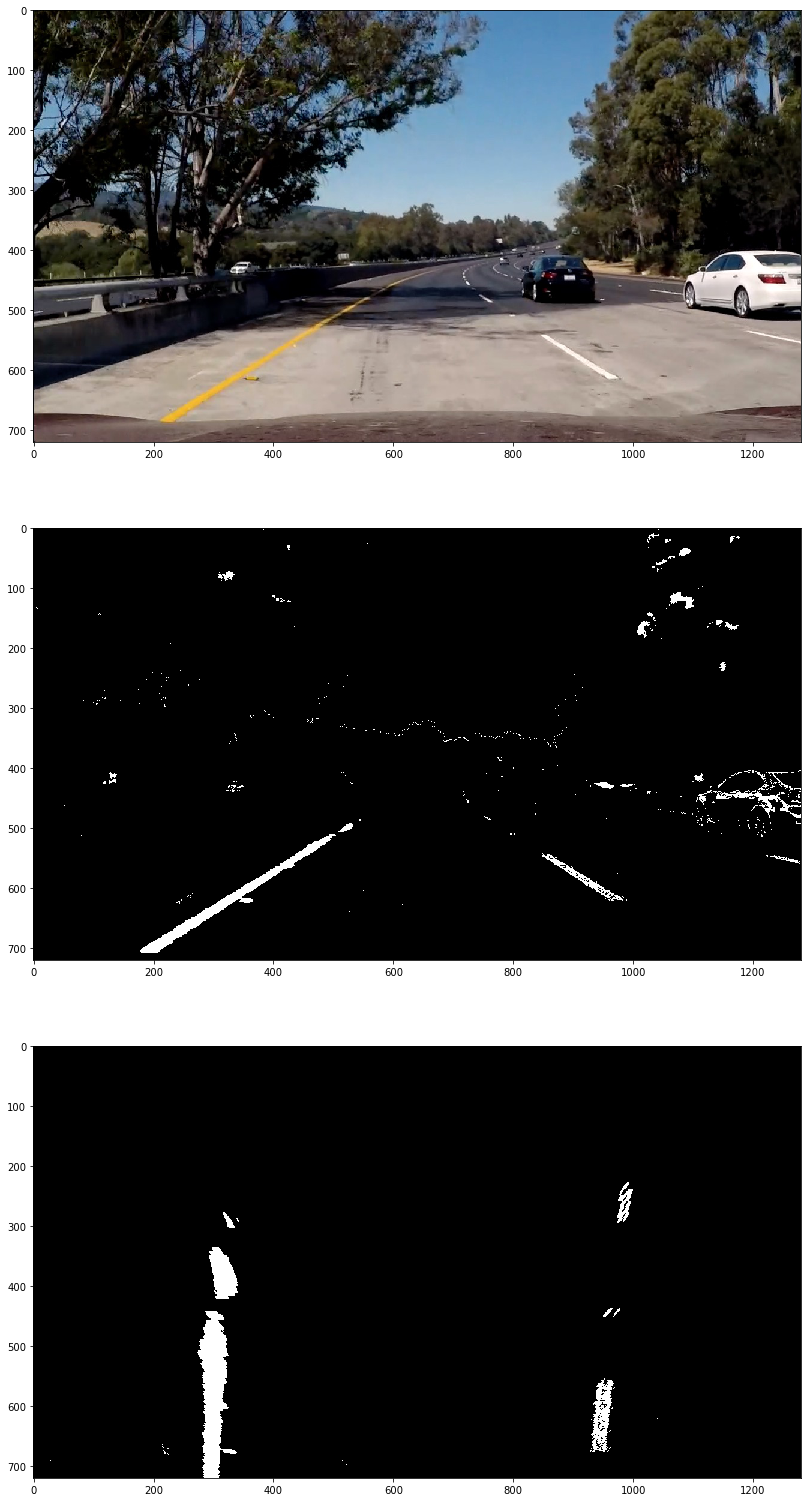

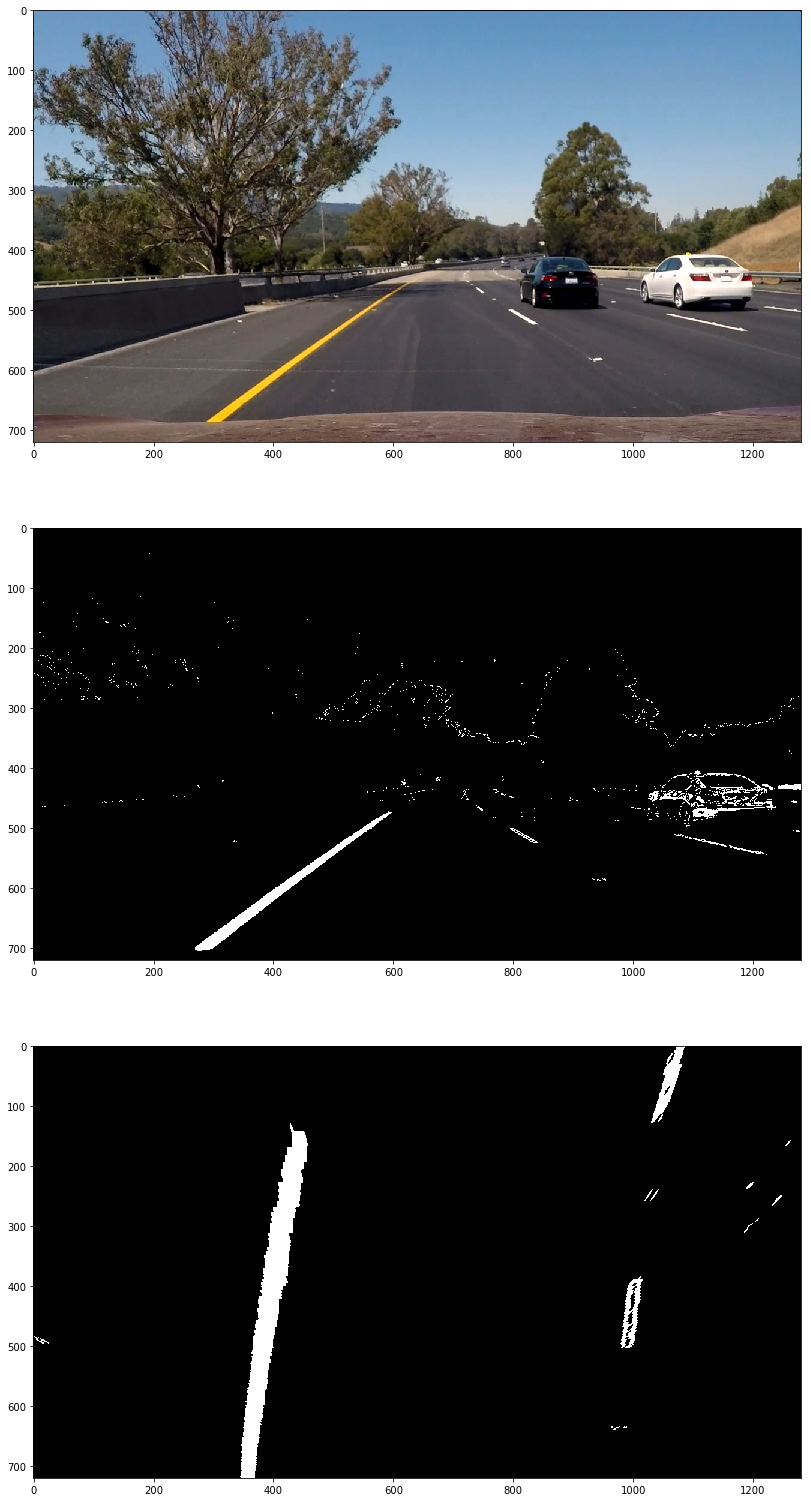

In [35]:
# Read in the test images
# Show the binary warped image
images = os.listdir('test_images/')
#print(images)
for image in images:
    img = mpimg.imread('test_images/'+image)
    
    combined_binary,binary_warped = warp_binary(img)
    plt.figure(figsize=(70, 27))
    plt.subplot(3,1,1)
    plt.imshow(img)
    plt.subplot(3,1,2)
    plt.imshow(combined_binary,cmap='gray')
    plt.subplot(3,1,3)
    plt.imshow(binary_warped,cmap='gray')
    plt.savefig('output_images/binary/'+'warp'+image)
    
    

In [11]:
# Define a function to implement line extraction using sliding windows

def slidewindow(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    # Define number of windows and window height
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identyfy all nonezero pixel positions in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current postion to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    #set the width of the window
    margin = 100
    #Set the minimum number of poxles found to recenter window
    minpix = 20
    
    #Creat empty lists to receive left and right lane pixles
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one   
    for window in range(nwindows):
        # Identify window boudaries in x and y 
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #Draw the windows on the visulization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
       
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & 
                            (nonzerox>=win_xleft_low) & (nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & 
                            (nonzerox>=win_xright_low) & (nonzerox<win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit, right_fit = (None, None) 
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [12]:
# Define a function that can search lines near the fit lines in previous frame
def lane_find_based_on_prev(binary_warped,left_fit_prev, right_fit_prev):
    # Extract non zero pixles
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # Define the search margin
    margin = 80
    # Extract non zeros pixles in the scope of +-margin
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = None
    right_fit_new = None
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty,leftx,2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty,rightx,2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [13]:
# Define curvature and center distance calcuation function
def curv_centdist_calc(binary_warped, left_lane_inds, right_lane_inds):
    # Define the mmeters per pixle
    xm_perpix = 3.7/700
    ym_perpix = 30/720
    ym_eval = binary_warped.shape[0]*ym_perpix
    # Initialize calculated curvature and center distance
    curvature, cent_dist = (0, 0)
    
    # Extract non zero pixles index of the binary image
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Use 2nd polyfit to calculate curvature and center distance in 'm'
    left_fit_cr, right_fit_cr = (None, None)
    left_curvature, right_curvature = (None, None)
    if len(leftx) != 0:
        left_fit_cr = np.polyfit(lefty*ym_perpix, leftx*xm_perpix,2)
        left_curvature = ((2 * left_fit_cr[0] * ym_eval + left_fit_cr[1]) ** 2 + 1) ** 1.5/np.absolute(2*left_fit_cr[0])
    if len(rightx) != 0:
        right_fit_cr = np.polyfit(righty*ym_perpix, rightx*xm_perpix,2)
        right_curvature = ((1 + (2*right_fit_cr[0]*ym_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if len(leftx) != 0 and len(rightx!=0): 
        curvature = (left_curvature + right_curvature)/2
    #Calculate middle postion of the image as the camera postion
    car_pos = binary_warped.shape[1]/2 * xm_perpix
    # Calculate the middle position of the lines nearest of the car
    if len(leftx) != 0 and len(rightx!=0):
        left_int = left_fit_cr[0] * (ym_eval**2) + left_fit_cr[1] * ym_eval + left_fit_cr[1]
        right_int = right_fit_cr[0] * (ym_eval**2) + right_fit_cr[1] * ym_eval + right_fit_cr[2]    
        cent_dist = car_pos - (left_int + right_int)/2
    return curvature, cent_dist

In [14]:
# Define a function to draw the lane lines on the undistorted images
def draw_lane(undist, binary_warped, left_fit, right_fit):
    
    if left_fit is None or right_fit is None:
        return undist
    
    ploty = np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #Creat an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack((left_fitx, ploty)))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack((right_fitx,ploty))))])
    pts = np.hstack((pts_left,pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)    
    _,new_warp = warp(color_warp)
    #Combine the result with the undistorted image
    result = cv2.addWeighted(undist, 1, new_warp,0.3,0)
    return result

In [15]:
# define a function to put the curvature and center distance on the image
def draw_data(undist,curvature,center_dist):
    data_img = np.copy(undist)
    
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:.2f}'.format(curvature) + ' m '
    #Put the curvature on the image
    cv2.putText(data_img, text, (35,70), font, 1.5, (200,255,100), 2, cv2.LINE_AA)
    if center_dist > 0:
        dir_c = 'right'
    else:
        dir_c = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:0.3f}'.format(abs_center_dist) + ' m ' + dir_c + ' of center'
    # Put the center distance on the image
    cv2.putText(data_img, text, (35,120), font, 1.5, (200,255,100), 2, cv2.LINE_AA)
    return data_img

In [16]:
# Draw lane lines on the test images
for image in images:
    img = mpimg.imread('test_images/'+image)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    _,binary_warped = warp_binary(img)
    margin = 100
    
    #Creat an output image to draw on
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    # # Fit a second order polynomial using slinding window method 
    left_fit, right_fit, left_lane_inds, right_lane_inds = slidewindow(binary_warped)
    #  # Identify the nonzero pixels in x and y within the window 
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty, rightx] = [0,0,255]
    # Recast the x and y points into usable format for cv2.fillPoly()  
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    # Creat a new image to draw on 
    window_img = np.zeros_like(out_img)
    # Draw lane lines
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.figure()
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)  
    plt.savefig('output_images/binary_Lane_lines/'+'Lane_line_withband_'+image)
    
    lane_line_warp = draw_lane(undist, binary_warped, left_fit, right_fit)
    
    # Put curvature and center distance on the image
    curvature, center_dist = curv_centdist_calc(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
    data_lane_img = draw_data(lane_line_warp, curvature, center_dist)
    plt.figure()
    plt.imshow(data_lane_img)
    
    
    
    # Generate some fake data to represent lane-line pixels
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # Fit a second order polynomial to pixel positions in each fake lane line
  
    #leftx = np.array([left_fit[0]*y**2 + left_fit[1]*y + left_fit[2] + np.random.randint(-50, high=51) 
    #                  for y in ploty])

    #rightx = np.array([right_fit[0]*y**2 + right_fit[1]*y + right_fit[2] + np.random.randint(-50, high=51) 
    #                  for y in ploty])
    

    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    #left_fit = np.polyfit(ploty, leftx, 2)
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fit = np.polyfit(ploty, rightx, 2)
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    #mark_size = 3
    #plt.figure()
    #plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    #plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    #plt.xlim(0, 1280)
    #plt.ylim(720,0)
    #plt.plot(left_fitx, ploty, color='green', linewidth=3)
    #plt.plot(right_fitx, ploty, color='green', linewidth=3)
    #plt.gca().invert_yaxis() # to visualize as we do the images

NameError: name 'images' is not defined

In [19]:
# Class definition
class line():
    def __init__(self):
        # was the line detected in the last iteration
        self.detected = False
        # polynominal coeeficients averaged over the last n iterations
        self.best_fit = None
        # polynominal coefficients for the most recent fit
        self.current_fit = []
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0],dtype='float')
    # Add a fit
    def add_fit(self,fit):
        if fit is not None:
            if self.best_fit is not None:
                #if a best_fit exists, there will be a comparison between the current and the best fit
                # If the difference between them is large, we will discard the current fit
                self.diffs = abs(fit - self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 150.) and (len(self.current_fit) > 0):
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                # Only keep 5 newest fits
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                # best fit is the average of the newest current fits
                self.best_fit = np.average(self.current_fit, axis = 0)
                
        else:
        # If the new fit is None, the current fits should discard the oldest one
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[1 : ]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis = 0)

In [20]:
# Define the pipeline of image processing
def process(img):
    # Convert the original image into binary warped image
    _,binary_warped = warp_binary(img)
    # Undistort the original image
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    # Fit the lines detected
    # If no line detected in the last iteration, detect lane lines using sliding window method 
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = slidewindow(binary_warped)
    # If lines can be found in the last iteration, search the new lines based on the last frame
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = lane_find_based_on_prev(binary_warped, l_line.best_fit, r_line.best_fit)
    
    # Add fit to the line class
    l_line.add_fit(left_fit)
    r_line.add_fit(right_fit)
    
    
    # Draw lane lines and put the curvature and center distance on the images
    if l_line.best_fit is not None and r_line.best_fit is not None:
        draw_line_img = draw_lane(undist, binary_warped, l_line.best_fit, r_line.best_fit)
        curvature, center_dist = curv_centdist_calc(binary_warped, l_line.best_fit, r_line.best_fit, left_lane_inds, right_lane_inds)
        out_img = draw_data(draw_line_img, curvature, center_dist)
    else:
        out_img = undist
    return out_img


    

In [102]:
l_line = line()
r_line = line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:14<00:00,  4.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 14s


In [21]:
l_line = line()
r_line = line()
video_output1 = 'challenge_video_out.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')
processed_video = video_input1.fl_image(process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|████████████████████████████████████████| 485/485 [01:42<00:00,  4.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

Wall time: 1min 43s


In [22]:
l_line = line()
r_line = line()
video_output1 = 'harder_challenge_video_out.mp4'
video_input1 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input1.fl_image(process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


100%|█████████████████████████████████████▉| 1199/1200 [04:34<00:00,  4.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

Wall time: 4min 35s
